使用条件对抗生成网络生成FashionMnist数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/FashionMNIST/"
EPOCHS = 100
BATCH_SIZE = 128
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1
NOISE_DIM = 100
LEARNING_RATE = 2e-4

In [2]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM + 10, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(inplace=True)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 128 * 7 * 7),
            torch.nn.BatchNorm1d(128 * 7 * 7),
            torch.nn.ReLU()
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 1, 4, 2, 1),
            torch.nn.Tanh()
        )

        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = x.view(-1, NOISE_DIM + 10)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv1(x)
        x = self.deconv2(x)

        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1 + 10, 64, 4, 2, 1),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# 3.导入数据

In [4]:
NetG = Generator()
NetD = Discriminator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = torch.nn.BCELoss()

trans = tv.transforms.Compose([tv.transforms.ToTensor()])

train_dataset = tv.datasets.FashionMNIST(root=DATA_PATH,
                               train=True,
                               transform=trans,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

fill = torch.zeros([10, 10, IMAGE_SIZE, IMAGE_SIZE])
for i in range(10):
    fill[i, i, :, :] = 1

onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)

temp_z_ = torch.randn(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10, 1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)
fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)

if torch.cuda.is_available():
    NetD = NetD.cuda()
    NetG = NetG.cuda()
    fixed_z_ = fixed_z_.cuda()
    fixed_y_label_ = fixed_y_label_.cuda()
    criterion.cuda()

with torch.no_grad():
    fixed_z_ = torch.autograd.Variable(fixed_z_)
    fixed_y_label_ = torch.autograd.Variable(fixed_y_label_)

# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f, G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    if epoch % 30 == 0:
        optimizerG.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10

    for img_real, label_real in train_loader:
        mini_batch = label_real.shape[0]

        label_true_var  = torch.autograd.Variable(torch.ones(mini_batch).cuda() if torch.cuda.is_available() else torch.ones(mini_batch))
        label_false_var = torch.autograd.Variable(torch.zeros(mini_batch).cuda() if torch.cuda.is_available() else torch.zeros(mini_batch))

        NetD.zero_grad()
        label_real = label_real.squeeze().type(torch.LongTensor)
        label_real = fill[label_real]

        image_var = torch.autograd.Variable(img_real.cuda() if torch.cuda.is_available() else img_real)
        label_var = torch.autograd.Variable(label_real.cuda() if torch.cuda.is_available() else label_real)

        d_result = NetD(image_var, label_var)
        d_result = d_result.squeeze()
        D_LOSS_REAL = criterion(d_result, label_true_var)

        img_fake = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        label_fake = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        img_fake_var     = torch.autograd.Variable(img_fake.cuda() if torch.cuda.is_available() else img_fake)
        label_fake_G_var = torch.autograd.Variable(onehot[label_fake].cuda() if torch.cuda.is_available() else onehot[label_fake])
        label_fake_D_var = torch.autograd.Variable(fill[label_fake].cuda() if torch.cuda.is_available() else fill[label_fake])

        g_result = NetG(img_fake_var, label_fake_G_var)
        d_result = NetD(g_result, label_fake_D_var)
        d_result = d_result.squeeze()
        D_LOSS_FAKE = criterion(d_result, label_false_var)

        D_train_loss = D_LOSS_REAL + D_LOSS_FAKE
        D_train_loss.backward()
        optimizerD.step()

        NetG.zero_grad()
        img_fake = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        label_fake = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        img_fake_var     = torch.autograd.Variable(img_fake.cuda() if torch.cuda.is_available() else img_fake)
        label_fake_G_var = torch.autograd.Variable(onehot[label_fake].cuda() if torch.cuda.is_available() else onehot[label_fake])
        label_fake_D_var = torch.autograd.Variable(fill[label_fake].cuda() if torch.cuda.is_available() else fill[label_fake])
        g_result = NetG(img_fake_var, label_fake_G_var)
        d_result = NetD(g_result, label_fake_D_var)
        d_result = d_result.squeeze()
        G_train_loss= criterion(d_result, label_true_var)
        G_train_loss.backward()
        optimizerG.step()

        showbar.show(epoch, D_train_loss.item(), G_train_loss.item())

Epoch:1 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.258, G Loss:0.847,total=0:01:110
Epoch:2 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.225, G Loss:0.822,total=0:01:080
Epoch:3 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.283, G Loss:0.923,total=0:01:100
Epoch:4 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.212, G Loss:0.890,total=0:01:11048:54
Epoch:5 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.214, G Loss:0.889,total=0:01:090:10:20
Epoch:6 / 100 [***************************************

Epoch:43 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.228, G Loss:2.214,total=0:01:350329:436
Epoch:44 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.113, G Loss:3.557,total=0:01:340:09:3197
Epoch:45 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.223, G Loss:3.886,total=0:01:300:23:599
Epoch:46 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.237, G Loss:3.392,total=0:01:330800:0896
Epoch:47 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.227, G Loss:4.166,total=0:01:300:17:1004
Epoch:48 / 100 [******

Epoch:84 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.060, G Loss:4.822,total=0:01:290:29:1801
Epoch:85 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.012, G Loss:6.918,total=0:01:320:03:4904
Epoch:86 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.015, G Loss:6.993,total=0:01:270:21:3476
Epoch:87 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:1.214, G Loss:1.033,total=0:01:340438:5524
Epoch:88 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.012, G Loss:6.053,total=0:01:270:14:1826
Epoch:89 / 100 [****

# 5.生成

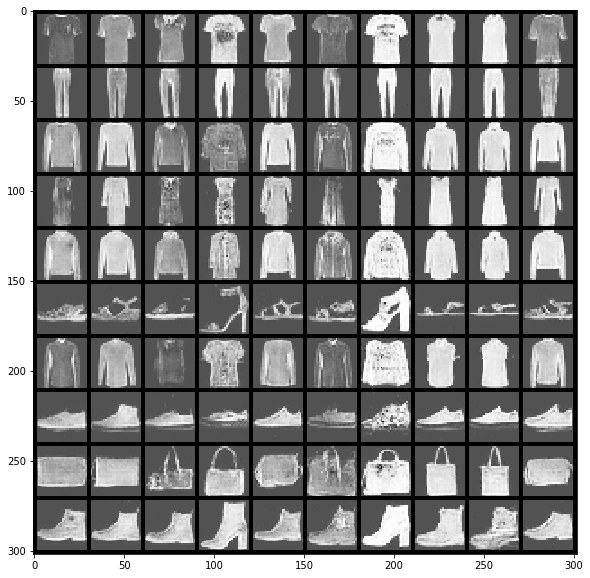

In [6]:
fake_u=NetG(fixed_z_, fixed_y_label_)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))